In [33]:
#Import the libraries we need
import pandas            as pd
import numpy             as np
import seaborn           as sns
import MetaTrader5       as mt5
import matplotlib.pyplot as plt
from   scipy.optimize    import  minimize

In [4]:
#Create the list of stocks
stocks = ["ADM.LSE","AAL.LSE","ANTO.LSE","AHT.LSE","AZN.LSE","ABF.LSE","AV.LSE","BARC.LSE","BP.LSE","BKG.LSE","UK100"]

In [13]:
#Initialize the terminal
if(!mt5.initialize()):
    print('Failed to load the MT5 Terminal')

True

In [39]:
#Create a dataframe to store our returns
amount  = 10000
returns = pd.DataFrame(columns=stocks,index=np.arange(0,amount))

In [115]:
#Fetch the data
for stock in stocks:
     temp = pd.DataFrame(mt5.copy_rates_from_pos(stock,mt5.TIMEFRAME_M1,0,amount))
     returns[[stock]] = temp[['close']]

In [116]:
#Store the data as returns
returns = returns.pct_change()
returns.dropna(inplace=True)

In [117]:
#Let's look at our dataframe
returns = returns * (10.0 ** 2)

In [119]:
returns

ADM.LSE   AAL.LSE  ANTO.LSE   AHT.LSE   AZN.LSE   ABF.LSE    AV.LSE  \
3     0.002007 -0.055733  0.055097 -0.038342 -0.001769  0.005676 -0.013950   
4     0.007359  0.007707  0.736183 -0.004022 -0.002231  0.053513  0.049829   
5     0.088975  0.002267 -0.011145 -0.004138  0.019078 -0.018639 -0.003984   
6    -0.104603 -0.002267  0.039808 -0.001752  0.027381  0.094426  0.037852   
7    -0.055534  0.023573 -0.028120  0.009297  0.018608  0.000000 -0.001991   
...        ...       ...       ...       ...       ...       ...       ...   
9995  0.002063  0.052709 -0.006755  0.010265  0.000415  0.000000 -0.002022   
9996  0.000000 -0.051741  0.009007 -0.120862 -0.019247 -0.048446  0.002022   
9997  0.034721  0.004706 -0.001689  0.000018  0.032942  0.001334  0.044474   
9998 -0.004811 -0.004235 -0.003940  0.008643  0.002571 -0.000889 -0.024248   
9999  0.000000  0.001412 -0.054606 -0.045434  0.015179 -0.002668  0.004042   

      BARC.LSE    BP.LSE   BKG.LSE     UK100  
3     0.004383  0.000000  0.006970  0.004860  
4     0.000000  0.011364 -0.001284  0.002430  
5     0.000000  0.024998  0.000000  0.010934  
6    -0.092049 -0.002272  0.000000 -0.020651  
7    -0.039486  0.011360  0.000000  0.003645  
...        ...       ...       ...       ...  
9995  0.071086  0.022057  0.000000  0.005993  
9996 -0.004440 -0.022052  0.002817 -0.009589  
9997  0.044399 -0.002451  0.001207  0.009589  
9998  0.004438 -0.022057 -0.039832 -0.005993  
9999 -0.071004  0.000000  0.000805 -0.003596  

[9997 rows x 11 columns]

<Axes: >

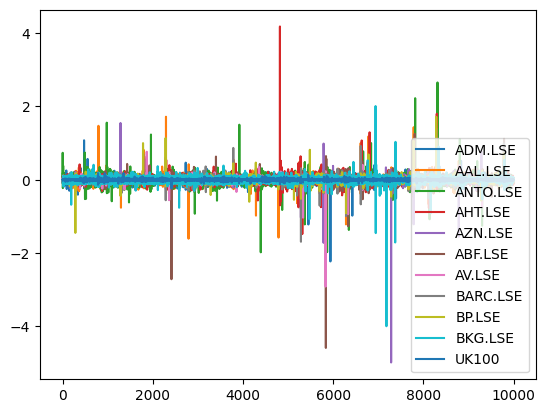

In [118]:
#Let's visualize our market returns
returns.plot()

<Axes: >

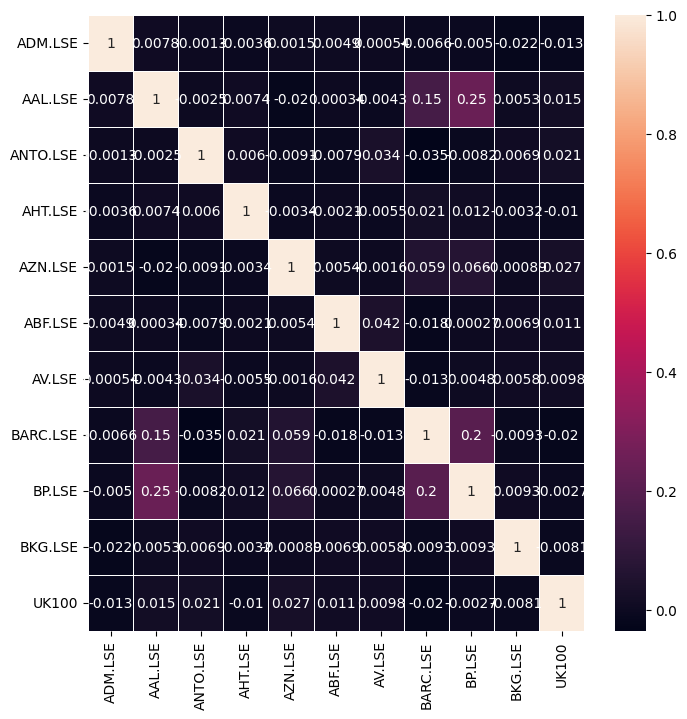

In [36]:
#Let's analyze the correlation coefficients
fig, ax = plt.subplots(figsize=(8,8)) 
sns.heatmap(returns.corr(),annot=True,linewidths=.5, ax=ax)

In [45]:
# Let's also analyze for lead-lag correlation
look_ahead  = 20
lead_lag    = pd.DataFrame(columns=stocks,index=np.arange(0,returns.shape[0] - look_ahead))
for stock in stocks:
    if stock == 'UK100':
        lead_lag[[stock]] = returns[[stock]].shift(-20)
    else:
        lead_lag[[stock]] = returns[[stock]].shift(20)

# Returns
lead_lag.dropna(inplace=True)

<Axes: >

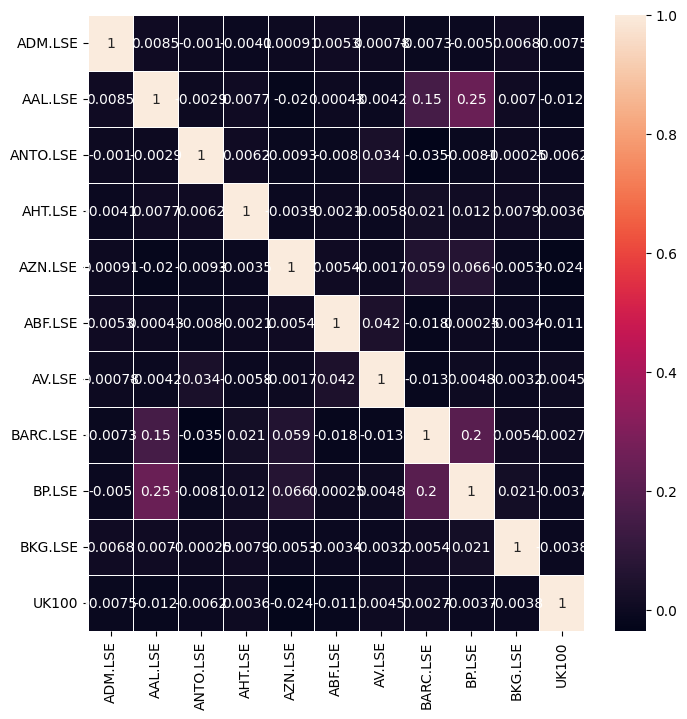

In [46]:
#Let's see if there are any stocks that are correlated with the future UK100 returns
fig, ax = plt.subplots(figsize=(8,8)) 
sns.heatmap(lead_lag.corr(),annot=True,linewidths=.5, ax=ax)

In [120]:
#Let's attempt to minimize the variance of the portfolio
weights = np.array([0,0,0,0,0,0,-1,1,1,0,0])
covariance = returns.cov()

In [121]:
#Store the initial portfolio variance
initial_portfolio_variance = np.dot(weights.T,np.dot(covariance,weights))
initial_portfolio_variance

0.011959689589562724

In [122]:
#Cost function
def cost_function(x):
    return(np.dot(x.T,np.dot(covariance,x)))

In [123]:
#Constraints
def l1_norm(x):
    return(np.sum(np.abs(x))) - 1

constraints = {'type': 'eq', 'fun':l1_norm}

In [124]:
#Initial guess
initial_guess = weights

In [125]:
#Add bounds
bounds =   [(-1,1)] * 11

In [126]:
#Minimize the portfolio variance
result = minimize(cost_function,initial_guess,method="SLSQP",constraints=constraints,bounds=bounds)

In [127]:
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.0004706570068070814
       x: [ 5.845e-02 -1.057e-01  8.800e-03  2.894e-02 -1.461e-01
            3.433e-02 -2.625e-01  6.867e-02  1.653e-01  3.450e-02
            8.675e-02]
     nit: 12
     jac: [ 3.820e-04 -9.886e-04  3.242e-05  4.724e-04 -1.544e-03
            4.151e-04 -1.351e-03  5.850e-04  8.880e-04  4.457e-04
            4.392e-05]
    nfev: 154
    njev: 12

In [128]:
#Store the optimal weights
optimal_weights = result.x

In [129]:
#Validating the weights add up to one
np.sum(np.abs(optimal_weights))

0.9999999998893961

In [130]:
#Store the new portfolio variance
otpimal_variance = cost_function(optimal_weights)

In [131]:
#Portfolio variance
portfolio_var = pd.DataFrame(columns=['Old Var','New Var'],index=[0])

In [132]:
portfolio_var.iloc[0,0] = initial_portfolio_variance * (10.0 ** 7)
portfolio_var.iloc[0,1] = otpimal_variance * (10.0 ** 7)

<Axes: >

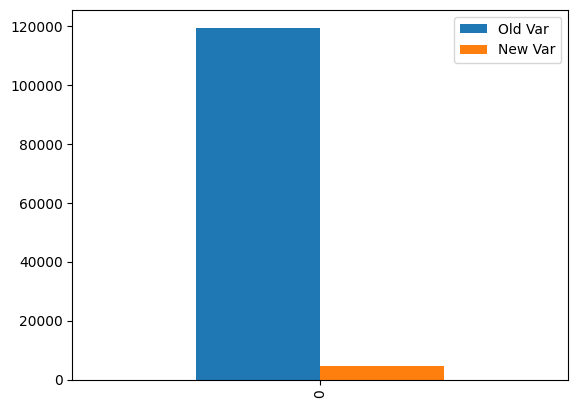

In [133]:
portfolio_var.plot.bar()

In [134]:
int_weights = (optimal_weights / optimal_weights[-1]) // 1
int_weights

array([ 0., -2.,  0.,  0., -2.,  0., -4.,  0.,  1.,  0.,  1.])

In [136]:
optimal_weights / optimal_weights[-1]

array([ 0.67378264, -1.21833078,  0.10145012,  0.33362298, -1.68480547,
        0.39576057, -3.0255541 ,  0.79159242,  1.90539402,  0.39772786,
        1.        ])